# Download images from Google

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/VOTE_DOC

/content/drive/MyDrive/VOTE_DOC


In [ ]:
%cd /content/drive/MyDrive/VOTE_DOC/

/content/drive/MyDrive/VOTE_DOC


In [ ]:
!ls -l | wc -l

51


In [ ]:
!cp /content/drive/MyDrive/VOTE_DOC/ds_sosedi/val/za/*.jpg .

# Imports

In [ ]:
import glob
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image, ImageReadMode

# Datasets and Dataloaders

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['png', 'jpg','JPG']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        class_set = set()
        for path in self.image_paths:
            class_set.add(os.path.basename(os.path.dirname(path)))
        self.class_lbl = { cls: i for i, cls in enumerate(sorted(list(class_set)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]

        return self.transform(img), torch.tensor(label)

In [ ]:
dataset = CustomDataset('ds_sos2/', transform)

In [ ]:
splits = [0.7, 0.3]

split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

train_set,  val_set = torch.utils.data.random_split(dataset, split_sizes)

In [ ]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=4, shuffle=True,drop_last=True),
 #   "test": DataLoader(test_set, batch_size=4, shuffle=False,drop_last=True),
    "val": DataLoader(val_set, batch_size=4, shuffle=False,drop_last=True)
}

# Model Definition

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(2048, 5)
model.to(device)
pass

In [ ]:
print(model)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training

In [ ]:
EPOCHS = 10
NUM_CLASSES = len(dataset.class_lbl)

In [ ]:
NUM_CLASSES

5

In [ ]:
device

'cuda'

In [ ]:
dataset.class_lbl

{'isporch': 0, 'negolos': 1, 'protiv': 2, 'vozderj': 3, 'za': 4}

In [ ]:
metrics = {
    'train': {'loss': [], 'accuracy': []},
    'val': {'loss': [], 'accuracy': []},
}

In [ ]:
for epoch in range(EPOCHS):
  ep_metrics = {
    'train': {'loss': 0, 'accuracy': 0, 'count': 0},
    'val': {'loss': 0, 'accuracy': 0, 'count': 0},
  }

  print(f'Epoch {epoch}')



  for phase in ['train', 'val']:
    print(f'-------- {phase} --------')
    for images, labels in tqdm(dataloaders[phase]):

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        output = model(images.to(device))

        ohe_label = torch.nn.functional.one_hot(torch.tensor(labels),
                                                num_classes=NUM_CLASSES)




        #loss = criterion(output, labels)
        loss = criterion(output, ohe_label.float().to(device))

        correct_preds = labels.to(device) == torch.argmax(output, dim=1)
        accuracy = (correct_preds).sum()/len(labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

      ep_metrics[phase]['loss'] += loss.item()
      ep_metrics[phase]['accuracy'] += accuracy.item()
      ep_metrics[phase]['count'] += 1

    ep_loss = ep_metrics[phase]['loss']/ep_metrics[phase]['count']
    ep_accuracy = ep_metrics[phase]['accuracy']/ep_metrics[phase]['count']

    print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

    metrics[phase]['loss'].append(ep_loss)
    metrics[phase]['accuracy'].append(ep_accuracy)

Epoch 0
-------- train --------


  0%|          | 0/411 [00:00<?, ?it/s]<ipython-input-53-bbaca3fc8e41>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ohe_label = torch.nn.functional.one_hot(torch.tensor(labels),
100%|██████████| 411/411 [04:51<00:00,  1.41it/s]


Loss: 0.6946627784049061, Accuracy: 0.7329683698296837

-------- val --------


100%|██████████| 176/176 [01:57<00:00,  1.50it/s]


Loss: 0.435793855079365, Accuracy: 0.8579545454545454

Epoch 1
-------- train --------


100%|██████████| 411/411 [00:18<00:00, 22.68it/s]


Loss: 0.2981247591974164, Accuracy: 0.9038929440389294

-------- val --------


100%|██████████| 176/176 [00:03<00:00, 49.50it/s]


Loss: 0.3379153886026787, Accuracy: 0.9076704545454546

Epoch 2
-------- train --------


100%|██████████| 411/411 [00:18<00:00, 22.39it/s]


Loss: 0.1646276947944776, Accuracy: 0.9507299270072993

-------- val --------


100%|██████████| 176/176 [00:04<00:00, 39.14it/s]


Loss: 0.24508848375196315, Accuracy: 0.9275568181818182

Epoch 3
-------- train --------


100%|██████████| 411/411 [00:18<00:00, 22.78it/s]


Loss: 0.15732261215233517, Accuracy: 0.9519464720194647

-------- val --------


100%|██████████| 176/176 [00:03<00:00, 49.00it/s]


Loss: 0.2977112391897456, Accuracy: 0.9275568181818182

Epoch 4
-------- train --------


100%|██████████| 411/411 [00:18<00:00, 22.35it/s]


Loss: 0.1564194731427914, Accuracy: 0.9604622871046229

-------- val --------


100%|██████████| 176/176 [00:04<00:00, 42.18it/s]


Loss: 0.24993396450670183, Accuracy: 0.9204545454545454

Epoch 5
-------- train --------


100%|██████████| 411/411 [00:18<00:00, 22.03it/s]


Loss: 0.10600276189032544, Accuracy: 0.9708029197080292

-------- val --------


100%|██████████| 176/176 [00:03<00:00, 47.63it/s]


Loss: 0.16468127559478904, Accuracy: 0.9545454545454546

Epoch 6
-------- train --------


100%|██████████| 411/411 [00:18<00:00, 22.52it/s]


Loss: 0.13007563888945067, Accuracy: 0.9610705596107056

-------- val --------


100%|██████████| 176/176 [00:03<00:00, 49.31it/s]


Loss: 0.1374866173851346, Accuracy: 0.9644886363636364

Epoch 7
-------- train --------


100%|██████████| 411/411 [00:18<00:00, 22.11it/s]


Loss: 0.05486970944699736, Accuracy: 0.9841849148418491

-------- val --------


100%|██████████| 176/176 [00:04<00:00, 40.90it/s]


Loss: 0.12100170843768865, Accuracy: 0.96875

Epoch 8
-------- train --------


100%|██████████| 411/411 [00:18<00:00, 22.58it/s]


Loss: 0.09922213534033719, Accuracy: 0.9750608272506083

-------- val --------


100%|██████████| 176/176 [00:03<00:00, 49.00it/s]


Loss: 0.11908425454748794, Accuracy: 0.9744318181818182

Epoch 9
-------- train --------


100%|██████████| 411/411 [00:22<00:00, 18.57it/s]


Loss: 0.10589903511827553, Accuracy: 0.9738442822384428

-------- val --------


100%|██████████| 176/176 [00:04<00:00, 41.26it/s]

Loss: 0.12971957117389882, Accuracy: 0.9673295454545454



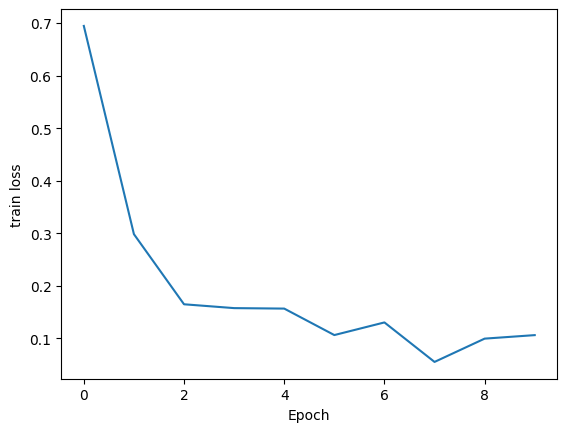

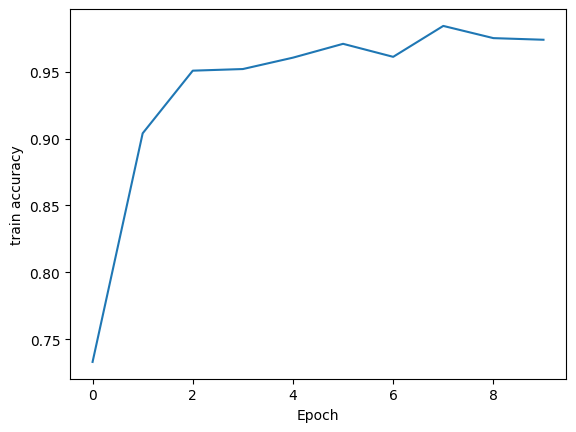

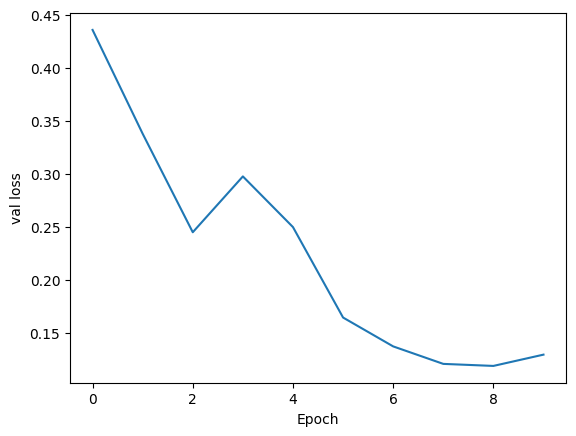

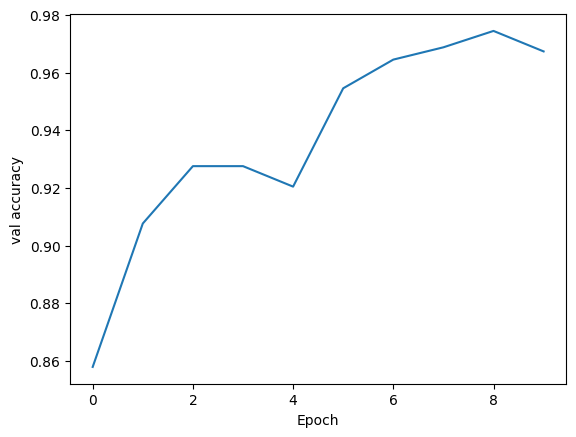

In [ ]:
for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.xlabel('Epoch')
        plt.ylabel(f'{phase} {metric}')
        plt.show()

# Testing

In [ ]:
preds = []
actual = []

tot_loss = tot_acc = count = 0

for images, labels in tqdm(dataloaders['val']):
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES)
        out_labels = torch.argmax(output, dim=1)


        tot_loss += criterion(output, ohe_label.float().to(device))
        tot_acc += (labels.to(device) == out_labels).sum()/len(labels)
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")

100%|██████████| 176/176 [00:03<00:00, 46.10it/s]

Test Loss: 0.11384522169828415, Test Accuracy: 0.9715909361839294


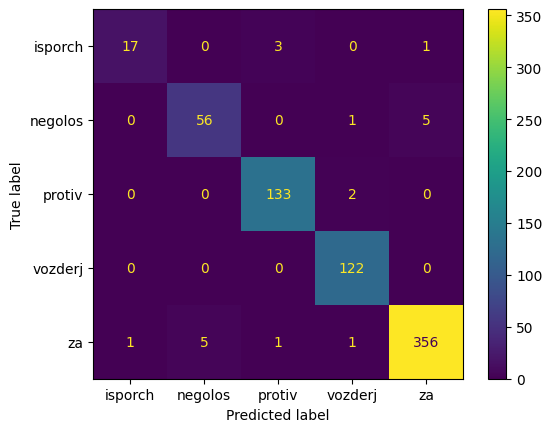

In [ ]:
class_labels = sorted(dataset.class_lbl.keys())

cm = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()
plt.show()

In [ ]:
cm_np = np.array(cm)
stats = pd.DataFrame(index=class_labels)
stats['Precision'] = [cm_np[i, i]/np.sum(cm_np[:, i]) for i in range(len(cm_np))]
stats['Recall'] = [cm_np[i, i]/np.sum(cm_np[i, :]) for i in range(len(cm_np))]

In [ ]:
stats

,Precision,Recall
0,1.000000,0.942857
1,1.000000,0.923077
2,0.928571,1.000000
3,0.500000,1.000000
4,1.000000,1.000000


In [ ]:
torch.save(model.state_dict(), 'vote_resnet50.pt')